Student: Christopher O'Hara </br>
ID: 37-217255 </br>
Environment: Google Colab</br>
HW: NLP Task</br>
Large-scale multi-label binarization with CNN-LSTM Implementation

Reference for Multilabel implementation:
https://keras.io/examples/nlp/multi_label_classification/

In [23]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [25]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [26]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


In [27]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [28]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [29]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [30]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [31]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [32]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cs.PL', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'math.DS', 'quant-ph', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'q-bio.GN', 'econ.EM', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'physics.geo-ph', 'q-fin.CP', 'physics.optics', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6

In [33]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV', 'cs.CL']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [34]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.436501
std         41.513020
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [35]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [36]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [37]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'This paper introduces a new real-time object detection approach named\nYes-Net. It realizes the prediction of bounding boxes and class via single\nneural network like YOLOv2 and SSD, but owns more efficient and outstanding\nfeatures. It combines local information with global information by adding the\nRNN architecture as a packed unit in CNN model to form the basic feature\nextractor. Independent anchor boxes coming from full-dimension k-means is also\napplied in Yes-Net, it brings better average IOU than grid anchor box. In\naddition, instead of NMS, Yes-Net uses RNN as a filter to get the final boxes,\nwhich is more efficient. For 416 x 416 input, Yes-Net achieves 79.2% mAP on\nVOC2007 test at 39 FPS on an Nvidia Titan X Pascal.'
Label(s): ['cs.CV']
 
Abstract: b'Reconstruction error is a prevalent score used to identify anomalous samples\nwhen data are modeled by generative models, such as (variational) auto-encoders\nor generative adversarial networks. This score relies

In [38]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


153529


In [39]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


In [64]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model

Epoch 1/40
258/258 [==============================] - 11s 42ms/step - loss: 0.0321 - categorical_accuracy: 0.8579 - val_loss: 0.0183 - val_categorical_accuracy: 0.9160
Epoch 2/40
258/258 [==============================] - 11s 41ms/step - loss: 0.0029 - categorical_accuracy: 0.8906 - val_loss: 0.0256 - val_categorical_accuracy: 0.8969
Epoch 3/40
258/258 [==============================] - 11s 41ms/step - loss: 8.3140e-04 - categorical_accuracy: 0.8453 - val_loss: 0.0304 - val_categorical_accuracy: 0.8756
Epoch 4/40
258/258 [==============================] - 11s 41ms/step - loss: 3.1520e-04 - categorical_accuracy: 0.8312 - val_loss: 0.0348 - val_categorical_accuracy: 0.8614
Epoch 5/40
258/258 [==============================] - 11s 43ms/step - loss: 1.7104e-04 - categorical_accuracy: 0.8202 - val_loss: 0.0382 - val_categorical_accuracy: 0.8652
Epoch 6/40
258/258 [==============================] - 11s 41ms/step - loss: 1.1295e-04 - categorical_accuracy: 0.8275 - val_loss: 0.0401 - val_categ

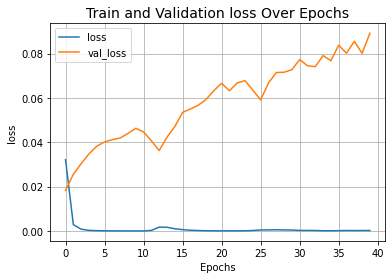

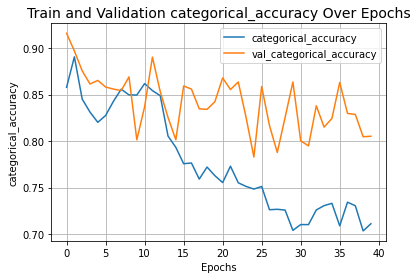

In [ ]:
epochs = 40

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 0s 24ms/step - loss: 0.0927 - categorical_accuracy: 0.7911
Categorical accuracy on the test set: 79.11%.


In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'Deep learning models exhibit a preference for statistical fitting over\nlogical reasoning. Spurious correlations might be memorized when there exists\nstatistical bias in training data, which severely limits the model performance\nespecially in small data scenarios. In this work, we introduce Counterfactual\nAdversarial Training framework (CAT) to tackle the problem from a causality\nperspective. Particularly, for a specific sample, CAT first generates a\ncounterfactual representation through latent space interpolation in an\nadversarial manner, and then performs Counterfactual Risk Minimization (CRM) on\neach original-counterfactual pair to adjust sample-wise loss weight\ndynamically, which encourages the model to explore the true causal effect.\nExtensive experiments demonstrate that CAT achieves substantial performance\nimprovement over SOTA across different downstream tasks, including sentence\nclassification, natural language inference and question answering.'
Label(s)

In [77]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Reshape(target_shape = (1, 256)),
            layers.Conv1D(256, 3, activation='relu',  padding='same'),
            layers.Reshape(target_shape = (1, 256)),
            layers.LSTM(128, dropout=0.05, recurrent_dropout=0.05, return_sequences = True),
            layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences = True),
            layers.Dense(64, activation='relu'),
            layers.LSTM(32, return_sequences = False),
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/40
258/258 [==============================] - 26s 63ms/step - loss: 0.1382 - categorical_accuracy: 0.4542 - val_loss: 0.0278 - val_categorical_accuracy: 0.4119
Epoch 2/40
258/258 [==============================] - 16s 60ms/step - loss: 0.0289 - categorical_accuracy: 0.5164 - val_loss: 0.0272 - val_categorical_accuracy: 0.5805
Epoch 3/40
258/258 [==============================] - 15s 59ms/step - loss: 0.0283 - categorical_accuracy: 0.5255 - val_loss: 0.0270 - val_categorical_accuracy: 0.4119
Epoch 4/40
258/258 [==============================] - 15s 59ms/step - loss: 0.0281 - categorical_accuracy: 0.5258 - val_loss: 0.0271 - val_categorical_accuracy: 0.4119
Epoch 5/40
258/258 [==============================] - 15s 58ms/step - loss: 0.0280 - categorical_accuracy: 0.5321 - val_loss: 0.0270 - val_categorical_accuracy: 0.4119
Epoch 6/40
258/258 [==============================] - 15s 58ms/step - loss: 0.0280 - categorical_accuracy: 0.5281 - val_loss: 0.0270 - val_categorical_accuracy:

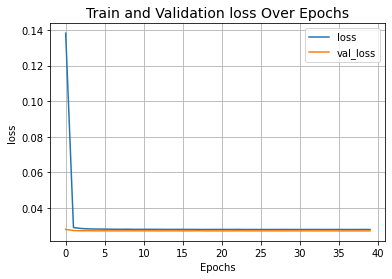

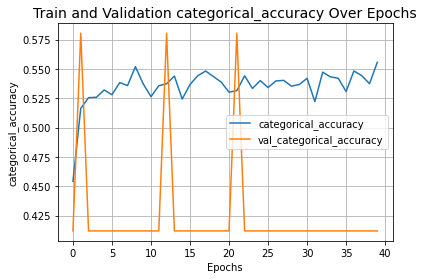

In [ ]:
epochs = 40

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 30ms/step - loss: 0.0268 - categorical_accuracy: 0.4092
Categorical accuracy on the test set: 40.92%.


In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'In crowded scenes, detection and localization of abnormal behaviors is\nchallenging in that high-density people make object segmentation and tracking\nextremely difficult. We associate the optical flows of multiple frames to\ncapture short-term trajectories and introduce the histogram-based shape\ndescriptor referred to as shape contexts to describe such short-term\ntrajectories. Furthermore, we propose a K-NN similarity-based statistical model\nto detect anomalies over time and space, which is an unsupervised one-class\nlearning algorithm requiring no clustering nor any prior assumption. Firstly,\nwe retrieve the K-NN samples from the training set in regard to the testing\nsample, and then use the similarities between every pair of the K-NN samples to\nconstruct a Gaussian model. Finally, the probabilities of the similarities from\nthe testing sample to the K-NN samples under the Gaussian model are calculated\nin the form of a joint probability. Abnormal events can be dete

In [84]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Reshape(target_shape = (1, 256)),
            layers.Conv1D(256, 3, activation='relu',  padding='same'),
            layers.Reshape(target_shape = (1, 256)),
            layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
            layers.LSTM(128, dropout=0.05, recurrent_dropout=0.05, return_sequences = True),
            layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences = True),
            layers.Dense(64, activation='relu'),
            layers.LSTM(32, return_sequences = False),
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/10
258/258 [==============================] - 27s 65ms/step - loss: 0.1318 - categorical_accuracy: 0.3986 - val_loss: 0.0274 - val_categorical_accuracy: 0.4119
Epoch 2/10
258/258 [==============================] - 18s 71ms/step - loss: 0.0285 - categorical_accuracy: 0.5124 - val_loss: 0.0270 - val_categorical_accuracy: 0.4119
Epoch 3/10
258/258 [==============================] - 17s 66ms/step - loss: 0.0282 - categorical_accuracy: 0.5204 - val_loss: 0.0270 - val_categorical_accuracy: 0.4119
Epoch 4/10
258/258 [==============================] - 18s 68ms/step - loss: 0.0280 - categorical_accuracy: 0.5305 - val_loss: 0.0270 - val_categorical_accuracy: 0.4119
Epoch 5/10
258/258 [==============================] - 17s 67ms/step - loss: 0.0280 - categorical_accuracy: 0.5275 - val_loss: 0.0270 - val_categorical_accuracy: 0.5805
Epoch 6/10
258/258 [==============================] - 16s 61ms/step - loss: 0.0279 - categorical_accuracy: 0.5291 - val_loss: 0.0270 - val_categorical_accuracy:

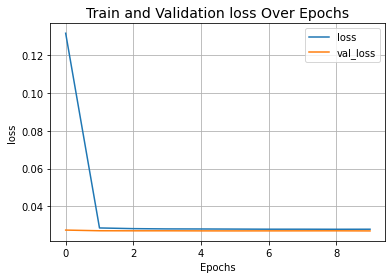

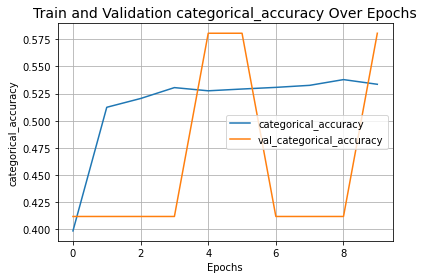

In [ ]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Reshape(target_shape = (1, 256)),
            layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/10
258/258 [==============================] - 28s 60ms/step - loss: 0.1122 - categorical_accuracy: 0.3971 - val_loss: 0.0275 - val_categorical_accuracy: 0.4119
Epoch 2/10
258/258 [==============================] - 13s 51ms/step - loss: 0.0290 - categorical_accuracy: 0.5165 - val_loss: 0.0272 - val_categorical_accuracy: 0.4119
Epoch 3/10
258/258 [==============================] - 13s 51ms/step - loss: 0.0285 - categorical_accuracy: 0.5215 - val_loss: 0.0271 - val_categorical_accuracy: 0.5805
Epoch 4/10
258/258 [==============================] - 13s 52ms/step - loss: 0.0282 - categorical_accuracy: 0.5300 - val_loss: 0.0272 - val_categorical_accuracy: 0.4119
Epoch 5/10
258/258 [==============================] - 14s 53ms/step - loss: 0.0281 - categorical_accuracy: 0.5309 - val_loss: 0.0271 - val_categorical_accuracy: 0.4119
Epoch 6/10
258/258 [==============================] - 13s 51ms/step - loss: 0.0281 - categorical_accuracy: 0.5279 - val_loss: 0.0270 - val_categorical_accuracy:

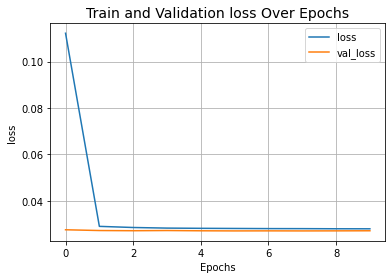

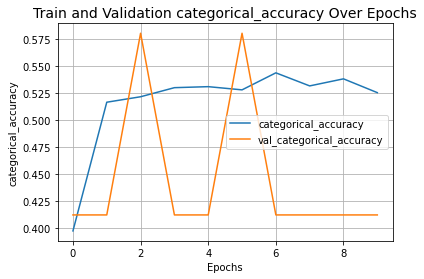

In [ ]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Reshape(target_shape = (1, 153380)),
            layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/10
258/258 [==============================] - 68s 218ms/step - loss: 0.1081 - categorical_accuracy: 0.5125 - val_loss: 0.0313 - val_categorical_accuracy: 0.5805
Epoch 2/10
258/258 [==============================] - 54s 209ms/step - loss: 0.0301 - categorical_accuracy: 0.5192 - val_loss: 0.0283 - val_categorical_accuracy: 0.5805
Epoch 3/10
258/258 [==============================] - 54s 209ms/step - loss: 0.0286 - categorical_accuracy: 0.5266 - val_loss: 0.0276 - val_categorical_accuracy: 0.4119
Epoch 4/10
258/258 [==============================] - 54s 208ms/step - loss: 0.0281 - categorical_accuracy: 0.5289 - val_loss: 0.0273 - val_categorical_accuracy: 0.4119
Epoch 5/10
258/258 [==============================] - 55s 211ms/step - loss: 0.0279 - categorical_accuracy: 0.5288 - val_loss: 0.0272 - val_categorical_accuracy: 0.4119
Epoch 6/10
258/258 [==============================] - 54s 208ms/step - loss: 0.0278 - categorical_accuracy: 0.5325 - val_loss: 0.0271 - val_categorical_acc

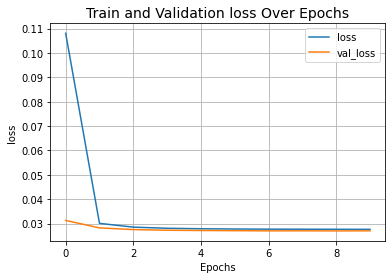

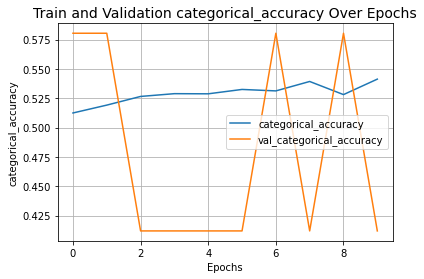

In [ ]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 83ms/step - loss: 0.0269 - categorical_accuracy: 0.4092
Categorical accuracy on the test set: 40.92%.


In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Reshape(target_shape = (1, 512)),
            layers.Conv1D(512, 3, activation='relu',  padding='same'),
            layers.Reshape(target_shape = (1, 512)),
            layers.Bidirectional(layers.LSTM(512, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(256, return_sequences=False)),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/10
258/258 [==============================] - 25s 47ms/step - loss: 0.0408 - categorical_accuracy: 0.5052 - val_loss: 0.0273 - val_categorical_accuracy: 0.5750
Epoch 2/10
258/258 [==============================] - 11s 42ms/step - loss: 0.0280 - categorical_accuracy: 0.5114 - val_loss: 0.0272 - val_categorical_accuracy: 0.4190
Epoch 3/10
258/258 [==============================] - 11s 42ms/step - loss: 0.0280 - categorical_accuracy: 0.5049 - val_loss: 0.0272 - val_categorical_accuracy: 0.5750
Epoch 4/10
258/258 [==============================] - 11s 42ms/step - loss: 0.0280 - categorical_accuracy: 0.5123 - val_loss: 0.0273 - val_categorical_accuracy: 0.4190
Epoch 5/10
258/258 [==============================] - 11s 43ms/step - loss: 0.0280 - categorical_accuracy: 0.5127 - val_loss: 0.0272 - val_categorical_accuracy: 0.5750
Epoch 6/10
258/258 [==============================] - 11s 43ms/step - loss: 0.0279 - categorical_accuracy: 0.5123 - val_loss: 0.0273 - val_categorical_accuracy:

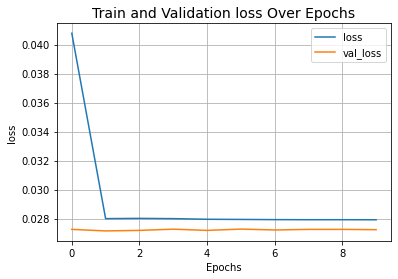

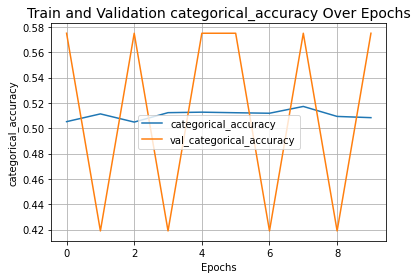

In [ ]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [73]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512*2, activation="relu"),
            layers.Reshape(target_shape = (1, 512*2)),
            layers.Bidirectional(layers.LSTM(512*2, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(256*2, return_sequences=False)),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/40
258/258 [==============================] - 24s 61ms/step - loss: 0.0353 - categorical_accuracy: 0.5047 - val_loss: 0.0273 - val_categorical_accuracy: 0.5750
Epoch 2/40
258/258 [==============================] - 15s 57ms/step - loss: 0.0244 - categorical_accuracy: 0.7585 - val_loss: 0.0201 - val_categorical_accuracy: 0.9067
Epoch 3/40
258/258 [==============================] - 15s 57ms/step - loss: 0.0199 - categorical_accuracy: 0.9275 - val_loss: 0.0198 - val_categorical_accuracy: 0.9171
Epoch 4/40
258/258 [==============================] - 15s 57ms/step - loss: 0.0186 - categorical_accuracy: 0.9431 - val_loss: 0.0199 - val_categorical_accuracy: 0.9182
Epoch 5/40
258/258 [==============================] - 15s 57ms/step - loss: 0.0176 - categorical_accuracy: 0.9389 - val_loss: 0.0202 - val_categorical_accuracy: 0.9116
Epoch 6/40
258/258 [==============================] - 15s 57ms/step - loss: 0.0165 - categorical_accuracy: 0.9391 - val_loss: 0.0207 - val_categorical_accuracy:

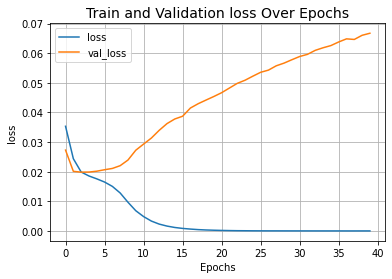

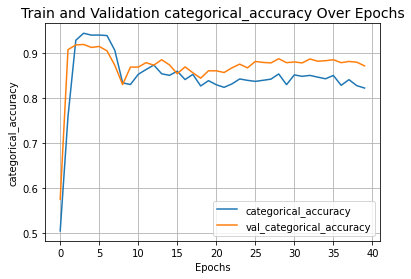

In [ ]:
epochs = 40

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 33ms/step - loss: 0.0694 - categorical_accuracy: 0.8560
Categorical accuracy on the test set: 85.6%.


In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'We consider a new form of reinforcement learning (RL) that is based on\nopportunities to directly learn the optimal control policy and a general Markov\ndecision process (MDP) framework devised to support these opportunities.\nDerivations of general classes of our control-based RL methods are presented,\ntogether with forms of exploration and exploitation in learning and applying\nthe optimal control policy over time. Our general MDP framework extends the\nclassical Bellman operator and optimality criteria by generalizing the\ndefinition and scope of a policy for any given state. We establish the\nconvergence and optimality-both in general and within various control paradigms\n(e.g., piecewise linear control policies)-of our control-based methods through\nthis general MDP framework, including convergence of $Q$-learning within the\ncontext of our MDP framework. Our empirical results demonstrate and quantify\nthe significant benefits of our approach.'
Label(s): ['cs.LG' 'sta

In [68]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512*2, activation="relu"),
            layers.Reshape(target_shape = (1, 512*2)),
            layers.LSTM(512*2, return_sequences=True),
            layers.LSTM(256*2, return_sequences=False),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

Epoch 1/40
258/258 [==============================] - 18s 56ms/step - loss: 0.0398 - categorical_accuracy: 0.5059 - val_loss: 0.0276 - val_categorical_accuracy: 0.5750
Epoch 2/40
258/258 [==============================] - 13s 50ms/step - loss: 0.0280 - categorical_accuracy: 0.5085 - val_loss: 0.0272 - val_categorical_accuracy: 0.5750
Epoch 3/40
258/258 [==============================] - 13s 50ms/step - loss: 0.0278 - categorical_accuracy: 0.5634 - val_loss: 0.0255 - val_categorical_accuracy: 0.8794
Epoch 4/40
258/258 [==============================] - 13s 50ms/step - loss: 0.0222 - categorical_accuracy: 0.9030 - val_loss: 0.0200 - val_categorical_accuracy: 0.9062
Epoch 5/40
258/258 [==============================] - 13s 50ms/step - loss: 0.0196 - categorical_accuracy: 0.9331 - val_loss: 0.0197 - val_categorical_accuracy: 0.9062
Epoch 6/40
258/258 [==============================] - 13s 50ms/step - loss: 0.0186 - categorical_accuracy: 0.9365 - val_loss: 0.0198 - val_categorical_accuracy:

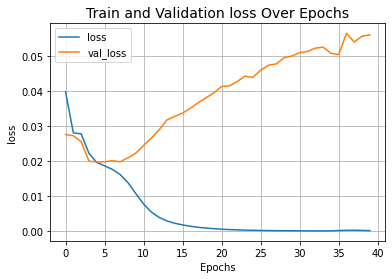

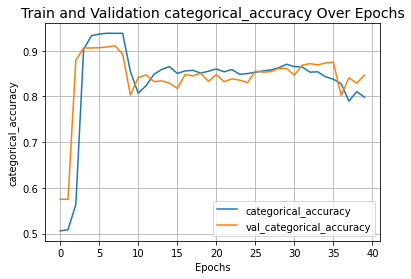

In [ ]:
epochs = 40

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 31ms/step - loss: 0.0571 - categorical_accuracy: 0.8478
Categorical accuracy on the test set: 84.78%.


In [81]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512*2, activation="relu"),
            layers.Reshape(target_shape = (1, 512*2)),
            layers.Conv1D(512*2, 3, activation='relu',  padding='same'),
            layers.Reshape(target_shape = (1, 512*2)),
            layers.Bidirectional(layers.LSTM(512*2, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(512, return_sequences=False)),
            layers.Dropout(rate=0.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ])

    return shallow_mlp_model

258/258 [==============================] - 28s 65ms/step - loss: 0.1358 - categorical_accuracy: 0.4719 - val_loss: 0.0276 - val_categorical_accuracy: 0.5663


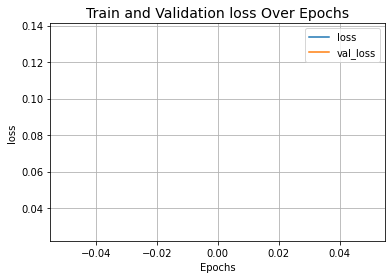

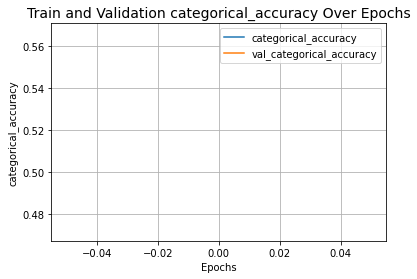

In [85]:
epochs = 1

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

Epoch 1/40
258/258 [==============================] - 24s 64ms/step - loss: 0.0361 - categorical_accuracy: 0.5002 - val_loss: 0.0274 - val_categorical_accuracy: 0.4190
Epoch 2/40
258/258 [==============================] - 15s 59ms/step - loss: 0.0282 - categorical_accuracy: 0.5058 - val_loss: 0.0273 - val_categorical_accuracy: 0.4190
Epoch 3/40
258/258 [==============================] - 15s 59ms/step - loss: 0.0283 - categorical_accuracy: 0.5135 - val_loss: 0.0275 - val_categorical_accuracy: 0.4190
Epoch 4/40
258/258 [==============================] - 15s 59ms/step - loss: 0.0283 - categorical_accuracy: 0.5082 - val_loss: 0.0274 - val_categorical_accuracy: 0.4190
Epoch 5/40
258/258 [==============================] - 16s 61ms/step - loss: 0.0282 - categorical_accuracy: 0.5085 - val_loss: 0.0274 - val_categorical_accuracy: 0.5750
Epoch 6/40
258/258 [==============================] - 15s 59ms/step - loss: 0.0283 - categorical_accuracy: 0.5036 - val_loss: 0.0274 - val_categorical_accuracy:

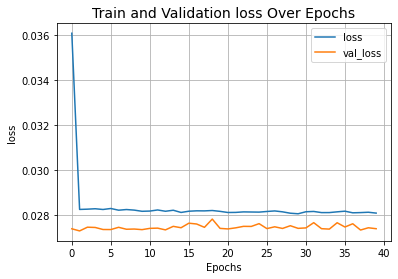

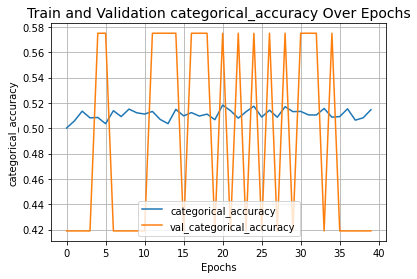

In [ ]:
epochs = 40

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

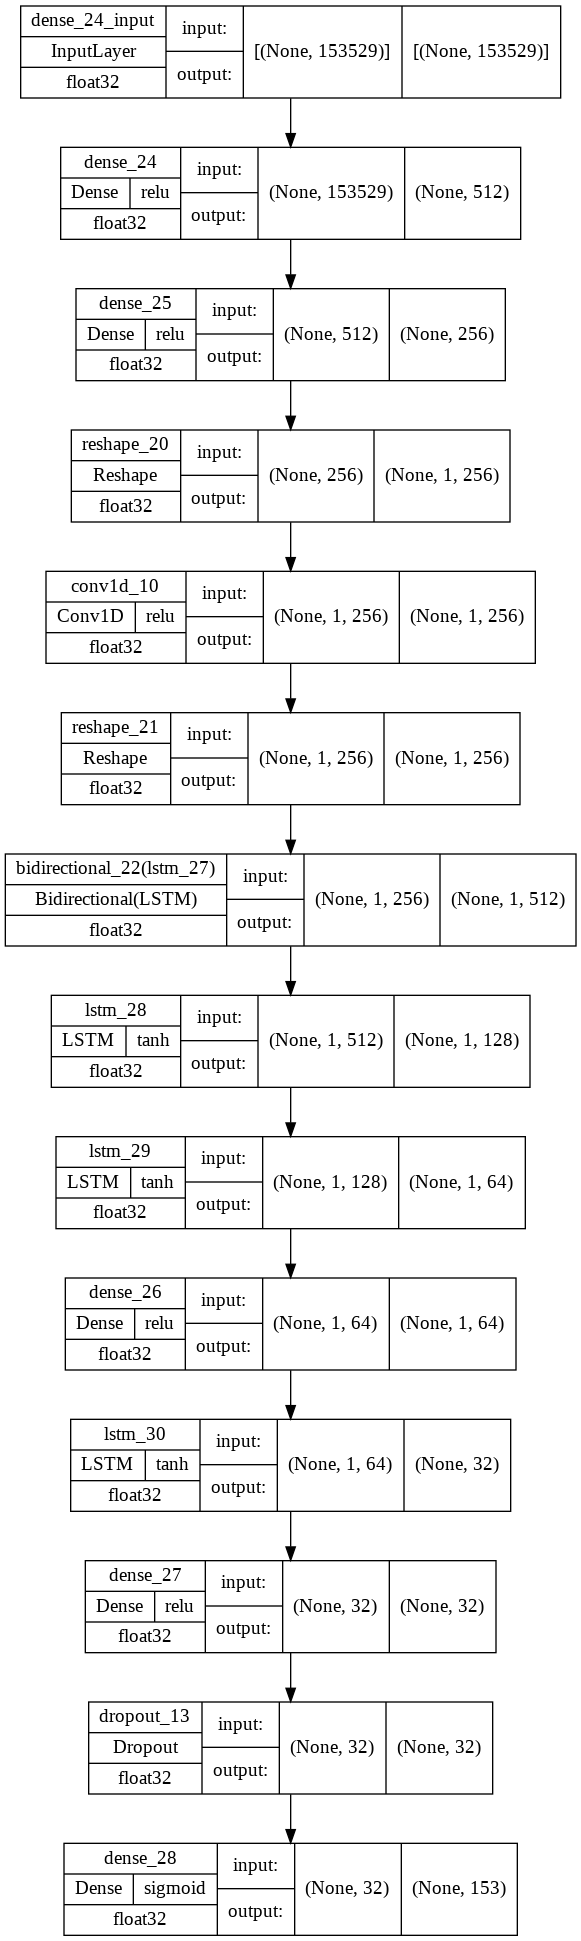

In [86]:
tf.keras.utils.plot_model(
    shallow_mlp_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [87]:
for layer in shallow_mlp_model.layers:
    print(layer.name, layer.input_shape,'->', layer.output_shape)
print(shallow_mlp_model.summary())

dense_24 (None, 153529) -> (None, 512)
dense_25 (None, 512) -> (None, 256)
reshape_20 (None, 256) -> (None, 1, 256)
conv1d_10 (None, 1, 256) -> (None, 1, 256)
reshape_21 (None, 1, 256) -> (None, 1, 256)
bidirectional_22 (None, 1, 256) -> (None, 1, 512)
lstm_28 (None, 1, 512) -> (None, 1, 128)
lstm_29 (None, 1, 128) -> (None, 1, 64)
dense_26 (None, 1, 64) -> (None, 1, 64)
lstm_30 (None, 1, 64) -> (None, 32)
dense_27 (None, 32) -> (None, 32)
dropout_13 (None, 32) -> (None, 32)
dense_28 (None, 32) -> (None, 153)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               78607360  
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 reshape_20 (Reshape)        (None, 1, 256)            0         
